In [1]:
import pandas as pd
import re
from nltk import word_tokenize
import nltk
import numpy as np
from sklearn.metrics import classification_report, plot_confusion_matrix
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk import FreqDist
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Shawn\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Shawn\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
data = pd.read_csv('judge_1377884607_tweet_product_company.csv')

In [3]:
data.head(10)

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,No emotion toward brand or product
6,NaN,NaN,No emotion toward brand or product
7,"#SXSW is just starting, #CTIA is around the co...",Android,Positive emotion
8,Beautifully smart and simple idea RT @madebyma...,iPad or iPhone App,Positive emotion
9,Counting down the days to #sxsw plus strong Ca...,Apple,Positive emotion


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8721 entries, 0 to 8720
Data columns (total 3 columns):
tweet_text                                            8720 non-null object
emotion_in_tweet_is_directed_at                       3169 non-null object
is_there_an_emotion_directed_at_a_brand_or_product    8721 non-null object
dtypes: object(3)
memory usage: 204.5+ KB


In [5]:
data[data['tweet_text'].isna()]

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
6,NaN,NaN,No emotion toward brand or product


In [6]:
data.drop(inplace= True, index=6)

In [7]:
data.head(10)

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,No emotion toward brand or product
7,"#SXSW is just starting, #CTIA is around the co...",Android,Positive emotion
8,Beautifully smart and simple idea RT @madebyma...,iPad or iPhone App,Positive emotion
9,Counting down the days to #sxsw plus strong Ca...,Apple,Positive emotion
10,Excited to meet the @samsungmobileus at #sxsw ...,Android,Positive emotion


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8720 entries, 0 to 8720
Data columns (total 3 columns):
tweet_text                                            8720 non-null object
emotion_in_tweet_is_directed_at                       3169 non-null object
is_there_an_emotion_directed_at_a_brand_or_product    8720 non-null object
dtypes: object(3)
memory usage: 272.5+ KB


In [ ]:
# %load "clean_lemmatize_token.py"
def clean_lemmatize_token(tweet):
    cleaned_tweet = re.sub(r"""['/,.;@#?!&$]+\ *""", " ", tweet, flags= re.VERBOSE).lower()
    tokenized_tweet = word_tokenize(cleaned_tweet)
    lemmatizer = WordNetLemmatizer()
    lemmatized_tweet = []
    for word in tokenized_tweet:
        lemmatized_tweet.append(lemmatizer.lemmatize(word))
    return lemmatized_tweet


In [10]:
tokens = []
for tweet in data['tweet_text']:
    tokens.append(clean_lemmatize_token(tweet))

In [11]:
len(tokens)

8720

In [12]:
tokens = pd.Series(tokens)

8720

In [13]:
corpus = []
for token in tokens:
    corpus += token

8720

In [14]:
freq = FreqDist(corpus)

In [15]:
freq.most_common(25)

[('sxsw', 9140),
 ('mention', 6951),
 ('the', 4294),
 ('link', 4131),
 ('}', 4109),
 ('{', 4107),
 ('to', 3480),
 ('at', 3009),
 ('rt', 2952),
 ('google', 2534),
 ('a', 2450),
 ('for', 2450),
 ('ipad', 2421),
 ('apple', 2204),
 (':', 1969),
 ('in', 1859),
 ('is', 1645),
 ('of', 1641),
 ('quot', 1621),
 ('and', 1573),
 ('i', 1523),
 ('iphone', 1513),
 ('store', 1451),
 ('on', 1289),
 ('s', 1241)]

In [16]:
text = ''
for word in corpus:
    text += word+' '

In [17]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate(text) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show(); 

<Figure size 800x800 with 1 Axes>

In [18]:
data.insert(2, 'tokens', tokens, True)

In [19]:
data.head()

,tweet_text,emotion_in_tweet_is_directed_at,tokens,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,"[wesley83, i, have, a, 3g, iphone, after, 3, h...",Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,"[jessedee, know, about, fludapp, awesome, ipad...",Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,"[swonderlin, can, not, wait, for, ipad, 2, als...",Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,"[sxsw, i, hope, this, year, s, festival, isn, ...",Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,"[sxtxstate, great, stuff, on, fri, sxsw, :, ma...",Positive emotion


In [20]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(solver= 'lbfgs', multi_class = 'auto', 
                            max_iter = 400, class_weight = 'balanced')
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data['tweet_text'])
Y = data['is_there_an_emotion_directed_at_a_brand_or_product']
logreg.fit(X,Y)

LogisticRegression(class_weight='balanced', max_iter=400)

In [21]:
y_pred = logreg.predict(X)
report = classification_report(Y, y_pred)

                                    precision    recall  f1-score   support

                      I can't tell       0.62      1.00      0.77       151
                  Negative emotion       0.74      0.99      0.85       545
No emotion toward brand or product       0.93      0.85      0.89      5155
                  Positive emotion       0.82      0.88      0.85      2869

                          accuracy                           0.87      8720
                         macro avg       0.78      0.93      0.84      8720
                      weighted avg       0.88      0.87      0.87      8720



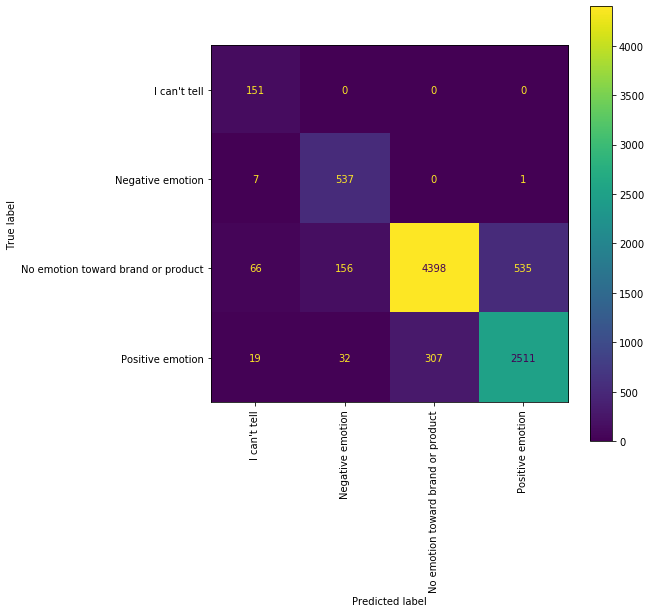

In [27]:
fig, ax = plt.subplots(figsize= (8,8))
plot_confusion_matrix(logreg, X, Y, ax=ax, xticks_rotation = 'vertical')
print(report)